# Linear Regression Assumption Workbook

## Author: James Christensen

## Initial Date: November 6, 2025

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

### Checking for multicolinearity

We have only two continous variables, so if their correlation has an absolute value less than 0.8 we can conclude that there is no multicolinearity

In [2]:
full_data = pd.read_csv('../data/cleaned_data.csv')
full_data = full_data.astype({col: int for col in full_data.select_dtypes('bool').columns})

full_data[['bmi', 'income']].corr()

,bmi,income
bmi,1.000000,-0.001902
income,-0.001902,1.000000


### Fitting the initial model

In [3]:


X = full_data.drop(columns = ['total_claims_paid', 'person_id'])
X = sm.add_constant(X)
y = full_data['total_claims_paid']

initial_model = sm.OLS(y, X).fit()
print(initial_model.summary())


                            OLS Regression Results                            
Dep. Variable:      total_claims_paid   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     77.51
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          3.70e-159
Time:                        19:58:50   Log-Likelihood:            -6.3978e+05
No. Observations:               69917   AIC:                         1.280e+06
Df Residuals:                   69906   BIC:                         1.280e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            896.1674     50.012     17.

Looking at the summary for this full model, it looks like a number of our variables aren't relevant to the model. The $R^2$ value being only 0.011 is fairly concerning. We'll see if the model can be better modeled with a transformation on Y. 

#### Transforming Y using box-cox

In [4]:
y = initial_model.model.endog  
y = y + 1e-6

y_boxcox, best_lambda = stats.boxcox(y)

print("Optimal lambda:", best_lambda)

Optimal lambda: 0.06744053363915475


Since the optimal lambda is essentially 0, we will perform a natural log transformation on total_claims_paid

In [5]:
y = full_data['total_claims_paid'] + 1e-6
y = np.log(y)
y_adjust_model = sm.OLS(y, X).fit()
print(y_adjust_model.summary())


                            OLS Regression Results                            
Dep. Variable:      total_claims_paid   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.807
Date:                Sat, 08 Nov 2025   Prob (F-statistic):             0.0538
Time:                        19:58:51   Log-Likelihood:            -2.6181e+05
No. Observations:               69917   AIC:                         5.236e+05
Df Residuals:                   69906   BIC:                         5.237e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.3008      0.225     -5.

This model actually did worse than the original one. As a result, we will check the assumptions of the original model and see if they hold.

### Checking the assumptions

#### Independence

One of the assumptions that we make with linear regression is that the observations are independent. Since each observation is an independent person it seems that the assumption is met. One possible way where the observations way not be completely independent is if two individuals come from the same household and have the same health insurance. It is also possible that there may be some repeat individuals as the data is sourced from "publicly available health surveys, insurance research studies, and anonymized online healthcare data." If any of these issues are present, it is safe to say that they are likely so few and far between that it is appropriate to conclude that the assumption of independence is effectively upheld

#### Normality of Errors

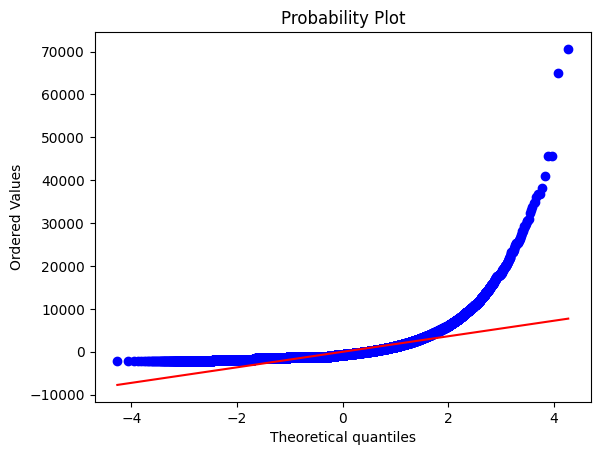

In [7]:
stats.probplot(initial_model.resid, dist = "norm", plot = plt)
plt.show()

This plot pretty clearly shows massive deviations from the theoretical quantile line. As such, it is pretty obvious that the assumption of normality is violated for the initial model. As such, we will check the other model and see if the normality assumption is violated as well

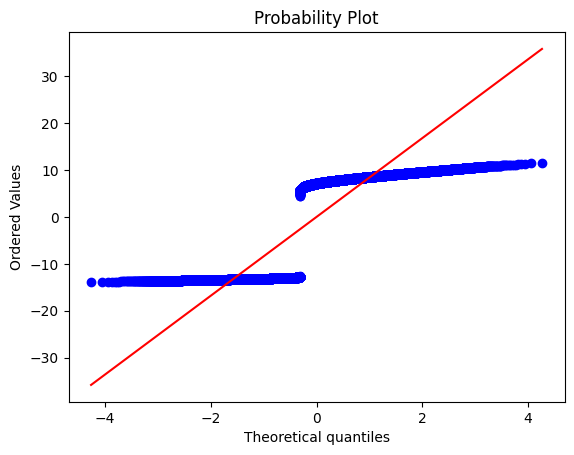

In [8]:
stats.probplot(y_adjust_model.resid, dist = "norm", plot = plt)
plt.show()

The assumption of normality is very clearly violated here as well. But it does appear to not be as extreme as the intial model. To quantify, we will use the Shapiro-Wilk test to compare which one more closely follows the theoretical quantiles

In [9]:
shapiro_i = stats.shapiro(initial_model.resid)
shapiro_y = stats.shapiro(y_adjust_model.resid)

print(f'The Shapiro-Wilk p-value for the initial model is {shapiro_i[1]}\nThe Shapiro-Wilk p-value for the adjusted model is {shapiro_y[1]}')

The Shapiro-Wilk p-value for the initial model is 1.3861329157502092e-141
The Shapiro-Wilk p-value for the adjusted model is 7.342979285513901e-138


c:\Users\legoe\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69917.
  res = hypotest_fun_out(*samples, **kwds)


There is essentially no alpha value at which the assumption of normality isn't violated.

#### Linearity


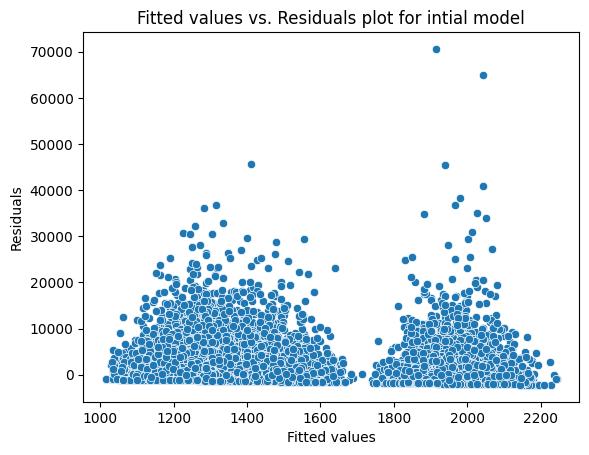

In [10]:
sns.scatterplot(x = initial_model.fittedvalues, y = initial_model.resid)
plt.title("Fitted values vs. Residuals plot for intial model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()


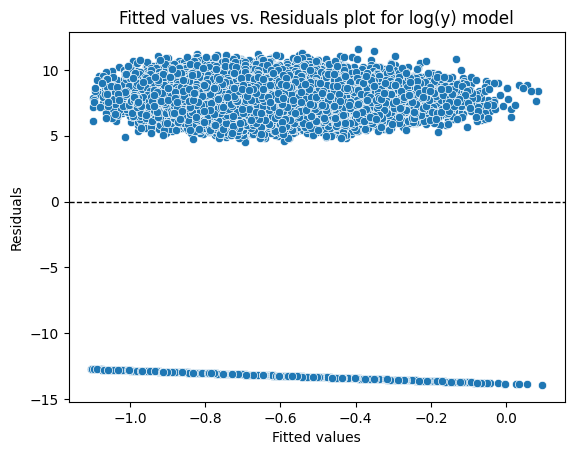

In [11]:
sns.scatterplot(x = y_adjust_model.fittedvalues, y = y_adjust_model.resid)
plt.title("Fitted values vs. Residuals plot for log(y) model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.show()

It appears from both the fitted residual plot and the qq plot that the linear model is both not appropriate, but also that two separate groups are emerging for the adjusted model. These groups appear to be 1. no claims were paid 2. at least 1 claim was paid. As such, it seems appropriate to abandon linear regression and instead model the data with logistic regression. This model would still help answer our initial research question, but this time, instead of how much it'll cost, it'll be modeling what is the probability that a lifestyle choice has a cost.

### Testing the multi group assumption

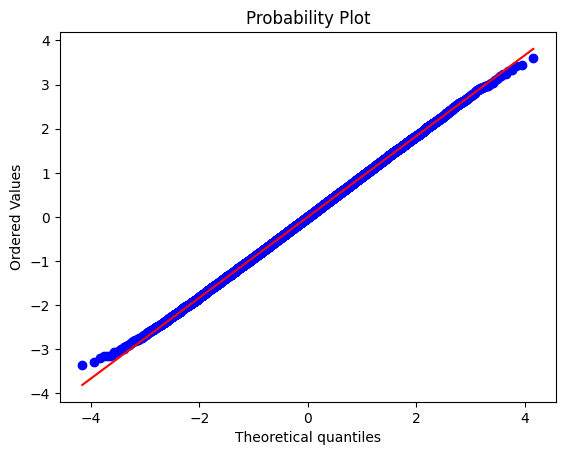

In [26]:
dat = full_data[full_data['total_claims_paid'] != 0]
Xmag = dat.drop(columns = ['total_claims_paid', 'person_id'])
Xmag = sm.add_constant(Xmag)
ymag = dat['total_claims_paid']
ymag = np.log(ymag)

magnitude_model = sm.OLS(ymag, Xmag).fit()
stats.probplot(magnitude_model.resid, dist = "norm", plot = plt)
plt.show()

The assumption of normality is almost perfectly met once we eliminated the group of individuals who made 0 claims. As such, it seems appropriate to now move forward and analyze the probability of having a claim vs. not.

### Modeling Magnitude?

After conducting the logistic regression, it appears that it is not possible to model, on lifestyle alone, whether a claim is paid or not. As such, it may be possible to model magnitude. Here is a summary of the model

In [23]:
magnitude_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total_claims_paid   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     130.4
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          5.68e-270
Time:                        20:44:30   Log-Likelihood:                -58088.
No. Observations:               43656   AIC:                         1.162e+05
Df Residuals:                   43645   BIC:                         1.163e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.8817      0.025    270.835      0.000       6.832       6.932
income         -3.442e-08   9.29e-08     -0.370      0.711   -2.17e-07    1.48e-07
bmi                0.0109      0.001     12.484      0.000       0.009       0.013
smoke_former       0.1443      0.012     12.522      0.000       0.122       0.167
smoker_current     0.4528      0.014     33.236      0.000       0.426       0.479
alcohol_weekly    -0.0012      0.010     -0.122      0.903      -0.021       0.018
alcohol_daily      0.0220      0.017      1.276      0.202      -0.012       0.056
suburban           0.0057      0.010      0.546      0.585      -0.015       0.026
rural              0.0177      0.013      1.401      0.161      -0.007       0.043
unemployed         0.0210      0.013      1.578      0.114      -0.005       0.047
retired           -0.0028      0.011     -0.252      0.801      -0.025       0.019
==============================================================================
Omnibus:                       12.741   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.267
Skew:                           0.024   Prob(JB):                      0.00217
Kurtosis:                       2.933   Cond. No.                     4.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Checking the assumptions of the magnitude model

#### Independence

The assumption of independence still stands and has the same explanation as the previous initial model

#### Normality

We have already generated a qq plot which appears to validate the assumption of normally distributed errors.

#### Linearity

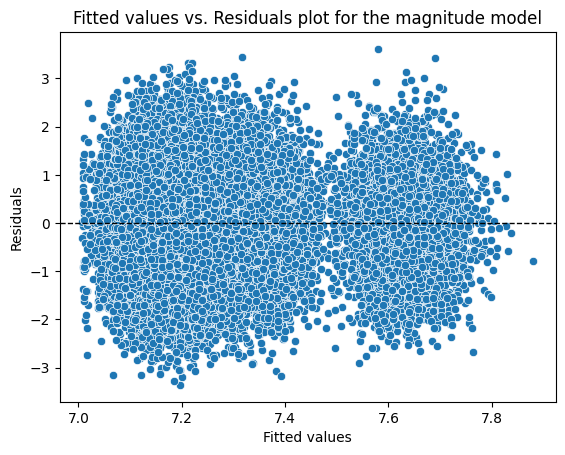

In [29]:
sns.scatterplot(x = magnitude_model.fittedvalues, y = magnitude_model.resid)
plt.title("Fitted values vs. Residuals plot for the magnitude model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.show()

This plot looks how we would it expect it to if the assumptions of linearity and homoscedasticity hold. There doesn't appear to be any pattern in the residuals and the variation doesn't seem to depend on the fitted values.

#### Conclusion

From the visuals, it does not appear that any of the assumptions of linear regression are violated. There are no significant deviations from the theoretical qq line and the fitted value vs. residual plot doesn't have any obvious patterns or seeming differences in variation. As such, we assume that the the errors are normally distributed with constant variance and that there is a linear relationship between the variables and log total claims paid.

### Inferences

From this model, it appears that only bmi and whether someone smokes or is a former smoker is statistically significant.